# 6. Modeling

Let's use models on data based on the feature engineering, data clean up, and data merging we performed in the previous notebook so we can make some predictions about when and where we can find West Nile Virus.

### Import modules and data

In [1]:
# !pip install -U imbalanced-learn

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

In [3]:
np.random.seed(42)

In [4]:
X = pd.read_csv('../data/train_weather_merged_dum.csv')
test = pd.read_csv('../data/test_weather_merged_dum.csv')
y = pd.read_csv('../data/target.csv')

In [5]:
X.set_index('date', inplace=True)

In [6]:
test.set_index('date', inplace=True)

In [7]:
X.shape, test.shape, y.shape

((10413, 179), (116293, 179), (10412, 1))

For some reason our csv reader is not reading in the last row, so let's add it manually for now:

In [8]:
y = y.append({'0': 0}, ignore_index=True)

In [9]:
y.shape

(10413, 1)

#### Check for imbalanced classes

We should always check for imbalanced classes and account for them.

In [10]:
y[y.columns[0]].value_counts()

0    9862
1     551
Name: 0, dtype: int64

In [11]:
y[y.columns[0]].value_counts(normalize=True)

0    0.947085
1    0.052915
Name: 0, dtype: float64

Our classes are really imbalanced! Only 5.5% of our data is of the positive class. We will have to account for this later.

### Train/test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y)

In [13]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [14]:
with open('../models/scaler.pkl', 'wb') as file:
    pickle.dump(ss, file)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7809, 179), (2604, 179), (7809, 1), (2604, 1))

### Balance Classes by oversampling (SMOTE)

In [16]:
sm = SMOTE(ratio = 'minority')
X_res, y_res = sm.fit_sample(X_train_sc, y_train)

/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
print(X_res.shape)
print(y_res.shape)

(14792, 179)
(14792,)


In [18]:
pd.Series(y_res).value_counts()

1    7396
0    7396
dtype: int64

Our number of observations increase because SMOTE creates new random samples in which our target equals 1. It also reduces the number of 0 classes have and makes them equal to the number of 1's we have.

### 2nd Train/test split on our re-balanced data

In [19]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_res, 
                                                            y_res,
                                                            stratify=y_res)

In [20]:
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape

((11094, 179), (3698, 179), (11094,), (3698,))

## 6A. Modeling

### Random Forest

Let's fit a Random Forest model on our re-balanced data. We will evaluate our model by interpreting the trade-off between our false positive rate and our true positive rate (ROC curve). The interpretation of the ROC curve is how many false positives do we need to 'incur' in order to arrive at a sufficiently high true positive rate. This will be determined by the probability threshold above which we believe there to be west nile present in a given trap. 

Said in another way, each point on the ROC curve represents a false positive rate/true positive rate pair corresponding to a particular decision threshold. The default threshold is 50% -- decreasing it below that (to say 5%) increases your false positives but also increases your true positive rate.

In our example, a high false positive rate can be thought of as blanketing the whole city with spray. We can't do that obviously (cost of spraying the entire city, health effects of spray, etc.), but we know we need to spray broadly at _some_ level because it is very hard to precisely identify where the virus will be.

If we try to get hyper-specific, we run the risk of missing areas where there is West Nile virus present. In that case, we would minimize false positives, but would also get a lot of false negatives. That is bad, because the virus would spread.

Net-net, you want to overestimate the number of areas with West Nile and spray there. You must do a cost-benefit analysis on this.

---

**Remember:** The data we are fitting our model on has already been scaled and rebalanced.

### Random Forest with GridSearch

#### Model

In [50]:
rf = RandomForestClassifier()
param_grid = {'n_estimators':[100], # tried 2,5,10,15,25,50,
            'criterion':['gini'], # tried entropy
            'max_depth':[20], # tried None,2,5,10
            'min_samples_split':[5] # tried 2,10
            }

gs_rf = GridSearchCV(rf, param_grid, scoring='roc_auc')
gs_rf.fit(X_train_2, y_train_2)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100], 'criterion': ['gini'], 'max_depth': [20], 'min_samples_split': [5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

#### Best parameters

In [51]:
gs_rf.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 5,
 'n_estimators': 100}

#### Comparing train and test scores (overfit)

In [52]:
gs_rf.score(X_train_sc, y_train), gs_rf.score(X_test_sc, y_test)

(0.949111456097596, 0.7915138639115153)

#### Make predictions

In [53]:
rf_preds = gs_rf.best_estimator_.predict(X_test_sc)

#### Confusion matrix

In [54]:
tn, fp, fn, tp = confusion_matrix(y_test, rf_preds).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 2412
False Positives: 54
False Negatives: 122
True Positives: 16


#### Precision / recall scores (at a 50% default threshold)

In [55]:
print(classification_report(y_test, rf_preds))

             precision    recall  f1-score   support

          0       0.95      0.98      0.96      2466
          1       0.23      0.12      0.15       138

avg / total       0.91      0.93      0.92      2604



Our Recall score for our positive class is terrible - 11%. However, let's also look at our ROC-AUC score:

#### ROC-AUC Score

In [56]:
proba_pairs = gs_rf.best_estimator_.predict_proba(X_test_sc)
rf_probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, rf_probas)

0.7915138639115153

#### Plot ROC Curve

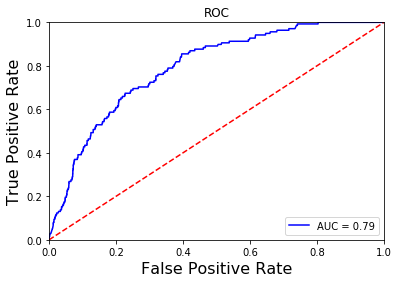

In [57]:
fpr, tpr, threshold = roc_curve(y_test, rf_probas)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title("ROC")
plt.legend(loc = 'lower right')
plt.show()

Not bad! Let's save this model.

In [58]:
model_file = 'rf.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_rf, file)

### RandomForest with SVD with GridSearch

In [1]:
###

#### Model

In [33]:
SVD = TruncatedSVD()
model = RandomForestClassifier()

In [34]:
pipe = Pipeline([
    ('svd', SVD),
    ('rf', model)
])

In [41]:
param_grid = {
    'rf__n_estimators': [200], 
    'rf__max_depth': [50],
    'rf__min_samples_split': [3],
    'svd__n_components': [150]
}
gs_rfsvd = GridSearchCV(pipe, param_grid, scoring='roc_auc')
gs_rfsvd.fit(X_train_2, y_train_2);

#### Best parameters

In [42]:
gs_rfsvd.best_params_

{'rf__max_depth': 50,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 200,
 'svd__n_components': 150}

#### Comparing train and test scores

In [43]:
gs_rfsvd.score(X_train_sc, y_train), gs_rfsvd.score(X_test_sc, y_test)

(0.9783192144958928, 0.6305934623928912)

#### Make predictions

In [44]:
rfsvd_preds = gs_rfsvd.best_estimator_.predict(X_test_sc)

#### Confusion matrix

In [45]:
tn, fp, fn, tp = confusion_matrix(y_test, rfsvd_preds).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 2359
False Positives: 107
False Negatives: 114
True Positives: 24


#### Precision / recall scores (at 50% threshold)

In [46]:
print(classification_report(y_test, rfsvd_preds))

             precision    recall  f1-score   support

          0       0.95      0.96      0.96      2466
          1       0.18      0.17      0.18       138

avg / total       0.91      0.92      0.91      2604



Our Recall score our positive class has improved to 17%, but our precision score has decreased. Let's look at our ROC_AUC score.

#### ROC-AUC Score

In [47]:
proba_pairs = gs_rfsvd.best_estimator_.predict_proba(X_test_sc)
rfsvd_probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, rfsvd_probas)

0.6305934623928912

#### Plot ROC Curve

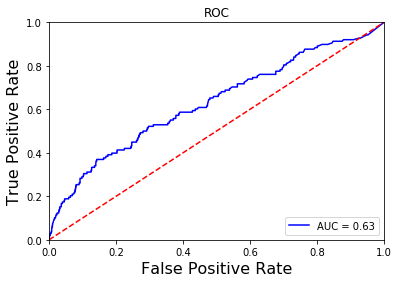

In [48]:
fpr, tpr, threshold = roc_curve(y_test, rfsvd_probas)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title("ROC")
plt.legend(loc = 'lower right')
plt.show()

Not a great model. Let's save this one too.

In [49]:
model_file = 'rfsvd.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_rfsvd, file)

### Logistic Regression with GridSearch

#### Model

In [59]:
logreg = LogisticRegression()
param_grid = {
    'penalty': ['l2'], 
    'C': [5]
}

gs_logreg = GridSearchCV(logreg, param_grid, scoring='roc_auc')
gs_logreg.fit(X_train_2, y_train_2)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2'], 'C': [5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

#### Best parameters

In [60]:
gs_logreg.best_params_

{'C': 5, 'penalty': 'l2'}

#### Comparing train and test scores

In [61]:
gs_logreg.score(X_train_sc, y_train), gs_logreg.score(X_test_sc, y_test)

(0.8203257896094611, 0.7322102330829718)

#### Make predictions

In [62]:
logreg_preds = gs_logreg.best_estimator_.predict(X_test_sc)

#### Confusion matrix

In [63]:
tn, fp, fn, tp = confusion_matrix(y_test, logreg_preds).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 1788
False Positives: 678
False Negatives: 58
True Positives: 80


#### Precision / recall scores (at 50% threshold)

In [64]:
print(classification_report(y_test, logreg_preds))

             precision    recall  f1-score   support

          0       0.97      0.73      0.83      2466
          1       0.11      0.58      0.18       138

avg / total       0.92      0.72      0.79      2604



Our Recall score our positive class has improved massively to 58%. This has come at the cost of identifying many false positives. There is a trade-off here so we have to look at the ROC-AUC tradeoff.

#### Make predictions and ROC-AUC Score

In [65]:
proba_pairs = gs_logreg.best_estimator_.predict_proba(X_test_sc)
logreg_probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, logreg_probas)

0.7322102330829718

#### Plot ROC Curve

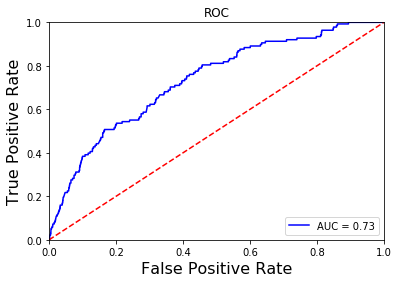

In [66]:
fpr, tpr, threshold = roc_curve(y_test, logreg_probas)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title("ROC")
plt.legend(loc = 'lower right')
plt.show()

This is a fairly good model with easy-to-interpret results. Let's save it.

In [67]:
model_file = 'logreg.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_logreg, file)

### AdaBoost with GridSearch

#### Model

In [68]:
ada = AdaBoostClassifier()
param_grid = {
    'algorithm': ['SAMME.R'],
    'n_estimators': [200]
    }

gs_ada = GridSearchCV(ada, param_grid, scoring='roc_auc')
gs_ada.fit(X_train_2, y_train_2)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'algorithm': ['SAMME.R'], 'n_estimators': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

#### Best parameters

In [69]:
gs_ada.best_params_

{'algorithm': 'SAMME.R', 'n_estimators': 200}

#### Comparing train and test scores

In [70]:
gs_ada.score(X_train_sc, y_train), gs_ada.score(X_test_sc, y_test)

(0.8428381220396602, 0.8019793833821127)

#### Make predictions

In [71]:
ada_preds = gs_ada.best_estimator_.predict(X_test_sc)

#### Confusion matrix

In [72]:
tn, fp, fn, tp = confusion_matrix(y_test, ada_preds).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 2374
False Positives: 92
False Negatives: 110
True Positives: 28


#### Precision / recall scores (at 50% threshold)

In [73]:
print(classification_report(y_test, ada_preds))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96      2466
          1       0.23      0.20      0.22       138

avg / total       0.92      0.92      0.92      2604



#### ROC-AUC Score

In [74]:
proba_pairs = gs_ada.best_estimator_.predict_proba(X_test_sc)
ada_probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, ada_probas)

0.8019793833821127

#### Plot ROC Curve

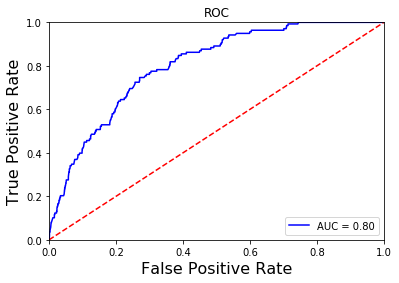

In [75]:
fpr, tpr, threshold = roc_curve(y_test, ada_probas)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title("ROC")
plt.legend(loc = 'lower right')
plt.show()

This is a very good model that performs well at the cost of high computational time. Let's save it.

In [76]:
model_file = 'ada.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_ada, file)

### GradientBoost with GridSearch

#### Model

In [77]:
gb = GradientBoostingClassifier()
param_grid = {
    'learning_rate': [0.1],
    'loss': ['exponential'],
    'n_estimators': [200],
    'max_depth': [5]
    }

gs_gb = GridSearchCV(gb, param_grid, scoring='roc_auc')
gs_gb.fit(X_train_2, y_train_2)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1], 'loss': ['exponential'], 'n_estimators': [200], 'max_depth': [5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

#### Best parameters

In [78]:
gs_gb.best_params_

{'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 5,
 'n_estimators': 200}

#### Comparing train and test scores

In [79]:
gs_gb.score(X_train_sc, y_train), gs_gb.score(X_test_sc, y_test)

(0.9267633050781982, 0.8126021133796443)

#### Make predictions

In [80]:
gb_preds = gs_gb.best_estimator_.predict(X_test_sc)

#### Confusion matrix

In [81]:
tn, fp, fn, tp = confusion_matrix(y_test, gb_preds).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 2412
False Positives: 54
False Negatives: 121
True Positives: 17


#### Precision / recall scores (at 50% threshold)

In [82]:
print(classification_report(y_test, gb_preds))

             precision    recall  f1-score   support

          0       0.95      0.98      0.96      2466
          1       0.24      0.12      0.16       138

avg / total       0.91      0.93      0.92      2604



#### ROC-AUC Score

In [83]:
proba_pairs = gs_gb.best_estimator_.predict_proba(X_test_sc)
gb_probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, gb_probas)

0.8126021133796443

#### Plot ROC Curve

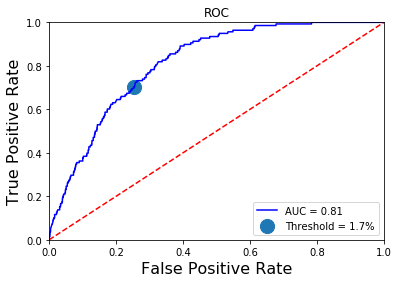

In [84]:
fpr, tpr, threshold = roc_curve(y_test, gb_probas)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.scatter(fpr[209], tpr[209], s=200, label='Threshold = 1.7%')
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title("ROC")
plt.legend(loc = 'lower right')
plt.show()

This is a [relatively] excellent model that performs well at the cost of high computational time. Let's save it.

In [85]:
model_file = 'gb.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_gb, file)

## 6B. Plots of Coefficients / Feature Importances

In [86]:
def plot_best_features(classifier, feature_names, top_features=15):
    # get top features
    coef = classifier.best_estimator_.feature_importances_.ravel()
    top_coefficients = np.argsort(coef)[-top_features:]

    # plot top features
    plt.figure(figsize=(7, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.barh(np.arange(1 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.yticks(
        np.arange(0, 1 * top_features),
        feature_names[top_coefficients],
        rotation=0, ha='right', fontsize=14)
    plt.xticks(fontsize = 14)

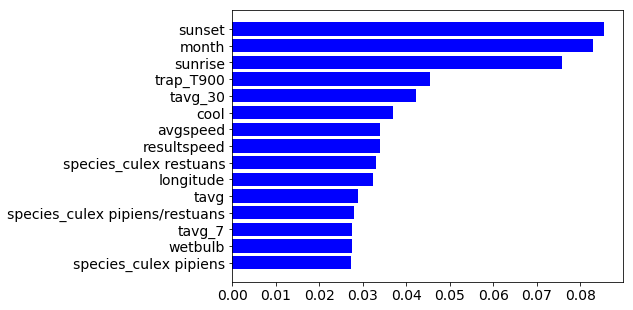

In [87]:
plot_best_features(gs_rf, X_train.columns)

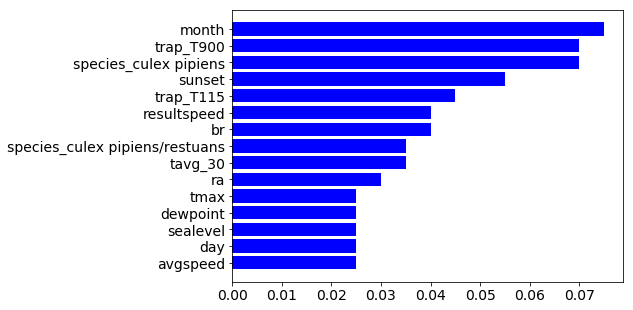

In [90]:
plot_best_features(gs_ada, X_train.columns)

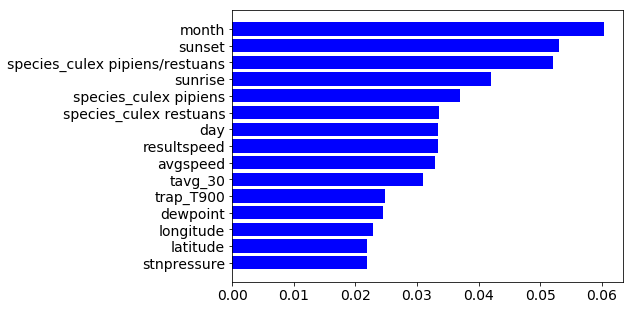

In [91]:
plot_best_features(gs_gb, X_train.columns)

In [92]:
def plot_coefficients(classifier, feature_names, top_features=15):
    # get top coefficients
    coef = classifier.best_estimator_.coef_.ravel()
    top_coefficients = np.argsort(coef)[-top_features:]

    # plot top features
    plt.figure(figsize=(7, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.barh(np.arange(1 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.yticks(
        np.arange(0, 1 * top_features),
        feature_names[top_coefficients],
        rotation=0, ha='right', fontsize=14)
    plt.xticks(fontsize = 14)

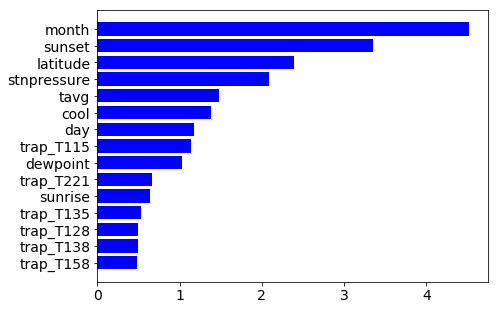

In [93]:
plot_coefficients(gs_logreg, X_train.columns)

## 6C. Plots of ROC-AUC Curves

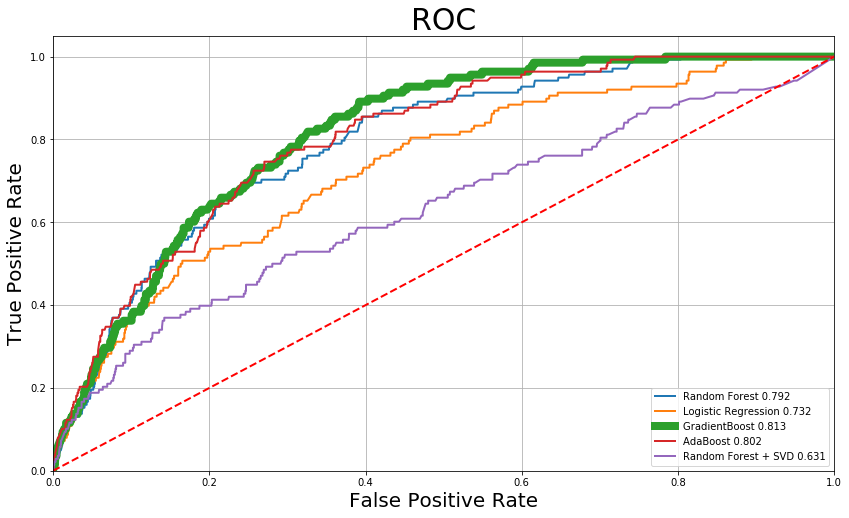

In [94]:
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_probas)
rf_roc_auc = auc(rf_fpr, rf_tpr)
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probas)
logreg_roc_auc = auc(logreg_fpr, logreg_tpr)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probas)
gb_roc_auc = auc(gb_fpr, gb_tpr)
ada_fpr, ada_tpr, _ = roc_curve(y_test, ada_probas)
ada_roc_auc = auc(ada_fpr, ada_tpr)
rfsvd_fpr, rfsvd_tpr, _ = roc_curve(y_test, rfsvd_probas)
rfsvd_roc_auc = auc(rfsvd_fpr, rfsvd_tpr)
Plotfig = plt.figure(figsize=(14,8))
line_width = 2

plt.plot(rf_fpr, rf_tpr, lw=line_width, label=f"Random Forest {round(rf_roc_auc, 3)}")
plt.plot(logreg_fpr, logreg_tpr, lw=line_width, label=f"Logistic Regression {round(logreg_roc_auc, 3)}")
plt.plot(gb_fpr, gb_tpr, lw=8, label=f"GradientBoost {round(gb_roc_auc, 3)}")
plt.plot(ada_fpr, ada_tpr, lw=line_width, label=f"AdaBoost {round(ada_roc_auc, 3)}")
plt.plot(rfsvd_fpr, rfsvd_tpr, lw=line_width, label=f"Random Forest + SVD {round(rfsvd_roc_auc, 3)}")

plt.plot([0,1], [0,1], lw=line_width, linestyle='--', color='r')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC', fontsize=30)
plt.legend(loc="lower right")
plt.grid(True)